#Exercise source
#https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d

# Configuration

In [1]:
# Parameters
GIT_NAME = 'ML1010_Weekly'

#Root Machine Learning Directory. Projects appear underneath
GOOGLE_DRIVE_MOUNT = '/content/gdrive' 
ML_DIRECTORY_COLAB = GOOGLE_DRIVE_MOUNT + '/MyDrive/Colab Notebooks'
PYTHON_UTIL_DIR_COLAB = GOOGLE_DRIVE_MOUNT + '/MyDrive/Colab Notebooks/utility_files'

ML_DIRECTORY_LOCAL = '/home/magni/Documents/ML_Projects'
PYTHON_UTIL_DIR_LOCAL = ML_DIRECTORY_LOCAL + '/utility_files'

#Enable for COLAB use, disable for local use
ENABLE_COLAB = True

# Bootstrap Environment

In [2]:
#add in support for utility file directory and importing
import sys
import os

if ENABLE_COLAB:
  #Need access to drive
  from google.colab import drive
  drive.mount(GOOGLE_DRIVE_MOUNT, force_remount=True)
  
  #add in utility directory to syspath to import 
  display("Adding COLAB path to sys: " + PYTHON_UTIL_DIR_COLAB)
  UTILITY_DIR = PYTHON_UTIL_DIR_COLAB
  sys.path.append(os.path.abspath(UTILITY_DIR))
  
  #Config environment variables
  ML_DIRECTORY = ML_DIRECTORY_COLAB
  
else:
  #add in utility directory to syspath to import
  display("Adding LOCAL path to sys: " + PYTHON_UTIL_DIR_LOCAL)
  UTILITY_DIR = PYTHON_UTIL_DIR_COLAB
  sys.path.append(os.path.abspath(UTILITY_DIR))
  
  #Config environment variables
  ML_DIRECTORY = ML_DIRECTORY_COLAB

#Utilities directory should be added
display(sys.path)

#Import Utility Support
from jarvis import Jarvis
jarvis = Jarvis(ML_DIRECTORY, GIT_NAME, UTILITY_DIR)

import mv_python_utils as mvutils

Mounted at /content/gdrive


'Adding COLAB path to sys: /content/gdrive/MyDrive/Colab Notebooks/utility_files'

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/MyDrive/Colab Notebooks/utility_files']



Jarvis is initializing...
I am setting the timezone
System initialization occurred at: 25-Nov-2021, 17:32
I am awake now.
I am configuring the environment...
Your current working directory is /content/gdrive/MyDrive/Colab Notebooks/ML1010_Weekly
Hello sir. Reminder, no more coffee.


You're current environment is configured as: 

GIT_NAME:     ML1010_Weekly
ML_DIRECTORY: /content/gdrive/MyDrive/Colab Notebooks
DATA_DIR:     /content/gdrive/MyDrive/Colab Notebooks/data/ML1010_Weekly
WORKING_DIR:  /content/gdrive/MyDrive/Colab Notebooks/ML1010_Weekly
UTILITY_DIR:  /content/gdrive/MyDrive/Colab Notebooks/utility_files


# Importing Necessary Libraries

In [3]:
#TO DO
#Step 1: Start removing these and see if you can get up to BERT setup

import pandas as pd
import numpy as np
np.random.seed(1337)

import datetime
from datetime import datetime

import math
#from keras import Sequential
#from tensorflow.keras.utils import Sequence
#from keras.layers import LSTM, Dense, Masking
#import numpy as np

#import keras
#from keras.utils import np_utils
#from keras import optimizers
#from keras.models import Sequential, Model
#from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation


#from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard

#import tensorflow as tf
#import tensorflow_hub as hub

# Loading The Data

In [4]:
train_raw = pd.read_csv(jarvis.DATA_DIR + '/complaints.csv.gz')
mvutils.exploreDataframe(train_raw)

dataframe shape: (2355756, 18)

dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355756 entries, 0 to 2355755
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64

None


Top 5 in dataframe


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2021-11-01,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt is not yours,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,LA,70507,NaN,NaN,Web,2021-11-10,In progress,Yes,NaN,4861881
2,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
3,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
4,2021-11-23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",NY,10473,NaN,NaN,Web,2021-11-23,In progress,Yes,NaN,4942356



Bottom 5 in dataframe


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
2355751,2017-02-09,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,I have disputed my debts several times with no...,NaN,Bonneville Billing and Collections,UT,NaN,Servicemember,Consent provided,Web,2017-02-09,Closed with explanation,Yes,No,2334969
2355752,2015-04-29,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,My father died in XX/XX/XXXX. Left me his only...,NaN,"CITIBANK, N.A.",OK,740XX,NaN,Consent provided,Web,2015-04-29,Closed with explanation,Yes,No,1352738
2355753,2017-03-31,Credit reporting,NaN,Credit reporting company's investigation,No notice of investigation status/result,cfbp i would Like to file a complaint on Exper...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MN,553XX,NaN,Consent provided,Web,2017-03-31,Closed with non-monetary relief,Yes,Yes,2412926
2355754,2017-01-16,Credit reporting,NaN,Incorrect information on credit report,Account status,My husband and I are in the middle of an FHA S...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,302XX,NaN,Consent provided,Web,2017-01-16,Closed with explanation,Yes,No,2292586
2355755,2018-03-07,Mortgage,Other type of mortgage,Trouble during payment process,NaN,NaN,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,91304,NaN,NaN,Referral,2018-03-08,Closed with explanation,Yes,NaN,2837068


# Preprocessing Data

Select non null:

In [5]:
focusCol = 'Consumer complaint narrative'

In [6]:
print(str(train_raw.shape))
train_raw = train_raw[train_raw[focusCol].notnull()]
print(str(train_raw.shape))

(2355756, 18)
(821617, 18)


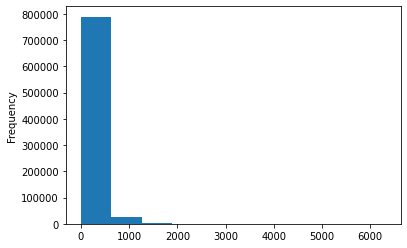

In [7]:
train_raw[focusCol].apply(lambda x: len(x.split())).plot(kind='hist')

In [8]:
train_raw['len_txt'] = train_raw[focusCol].apply(lambda x: len(x.split()))
train_raw.describe()

,Complaint ID,len_txt
count,8.216170e+05,821617.000000
mean,3.206297e+06,190.287933
std,8.708150e+05,226.916238
min,1.290155e+06,1.000000
25%,2.654470e+06,66.000000
50%,3.246880e+06,125.000000
75%,3.855518e+06,233.000000
max,4.885060e+06,6314.000000


In [9]:
train_raw.shape

(821617, 19)

Select only the row with number of words greater than 250:

In [10]:
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(186176, 19)

In [11]:
train_raw = train_raw[[focusCol, 'Product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,Consumer complaint narrative,Product
0,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease
1,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o..."
2,Although I am checking for and addressing miss...,"Credit reporting, credit repair services, or o..."
3,"In an attempt to purchase concert tickets, I c...","Money transfer, virtual currency, or money ser..."
4,I am attempting to sell my home and pay off my...,Mortgage


In [12]:
train_raw.info()
i = 0
for l in np.unique(train_raw['Product']):
    i += 1
    print(l)
print("\n--->Unique values: " + str(i))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186176 entries, 0 to 186175
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Consumer complaint narrative  186176 non-null  object
 1   Product                       186176 non-null  object
dtypes: object(2)
memory usage: 2.8+ MB
Bank account or service
Checking or savings account
Consumer Loan
Credit card
Credit card or prepaid card
Credit reporting
Credit reporting, credit repair services, or other personal consumer reports
Debt collection
Money transfer, virtual currency, or money service
Money transfers
Mortgage
Other financial service
Payday loan
Payday loan, title loan, or personal loan
Prepaid card
Student loan
Vehicle loan or lease
Virtual currency

--->Unique values: 18


Group similar products

In [13]:
#Cool code to group items categories
train_raw.info()
train_raw.at[train_raw['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['Product'] == 'Prepaid card', 'Product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186176 entries, 0 to 186175
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Consumer complaint narrative  186176 non-null  object
 1   Product                       186176 non-null  object
dtypes: object(2)
memory usage: 2.8+ MB


,Consumer complaint narrative,Product
0,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease
1,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o..."
2,Although I am checking for and addressing miss...,"Credit reporting, credit repair services, or o..."
3,"In an attempt to purchase concert tickets, I c...","Money transfer, virtual currency, or money ser..."
4,I am attempting to sell my home and pay off my...,Mortgage


In [14]:
i = 0
for l in np.unique(train_raw['Product']):
    i += 1
    print(l)
print("\n--->Unique values: " + str(i))

Bank account or service
Checking or savings account
Consumer Loan
Credit card or prepaid card
Credit reporting, credit repair services, or other personal consumer reports
Debt collection
Money transfer, virtual currency, or money service
Money transfers
Mortgage
Other financial service
Payday loan, title loan, or personal loan
Student loan
Vehicle loan or lease

--->Unique values: 13


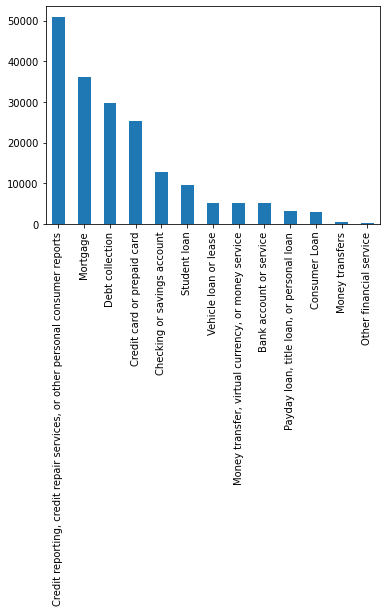

In [15]:
train_raw['Product'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [16]:
train_raw=train_raw.rename(columns = {focusCol:'text', 'Product':'label'})
train_raw.head()

,text,label
0,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease
1,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o..."
2,Although I am checking for and addressing miss...,"Credit reporting, credit repair services, or o..."
3,"In an attempt to purchase concert tickets, I c...","Money transfer, virtual currency, or money ser..."
4,I am attempting to sell my home and pay off my...,Mortgage


In [17]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,I contacted Ally on Friday XX/XX/XXXX after fa...,12
1,Hello This complaint is against the three cred...,4
2,Although I am checking for and addressing miss...,4
3,"In an attempt to purchase concert tickets, I c...",6
4,I am attempting to sell my home and pay off my...,8


In [18]:
len(np.unique(train_raw['label']))

13

In [19]:
train = train_raw.copy()

In [20]:
#index shuffle?
train = train.reindex(np.random.permutation(train.index))
display(train.shape)
display(train.head())

(186176, 2)

,text,label
147041,"I contacted "" American Neighborhood Mortgage A...",8
13415,XX/XX/20 : I tried logging into account at cha...,1
156545,My student loans are with Navient I applied to...,11
46635,"In XX/XX/XXXX and XX/XX/XXXX, I contacted Citi...",3
22544,My wife incurred a medical bill from XXXX Spec...,5


Clean the text columns

In [21]:
import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text

In [22]:
train['text']  = train.text.apply(clean_txt)
display(train.shape)
display(train.head())

(186176, 2)

,text,label
147041,I contacted American Neighborhood Mortgage Acc...,8
13415,XX XX 20 I tried logging into account at chase...,1
156545,My student loans are with Navient I applied to...,11
46635,In XX XX XXXX and XX XX XXXX I contacted Citib...,3
22544,My wife incurred a medical bill from XXXX Spec...,5


In [23]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
display(train.shape)
display(val.shape)
display(train.head())

(148940, 2)

(37236, 2)

,text,label
106616,In late XX XX 2020 I noticed a charge on my ac...,1
13934,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX I...,5
54343,Hi and how are you doing Im not sure who to ta...,4
179993,Navient made it difficult to get ahead of my p...,11
41545,This letter is being sent to you in response t...,4


In [24]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,In late XX XX 2020 I noticed a charge on my ac...,1
1,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX I...,5


In [25]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label
0,In XXXX XXXX I spoke with XXXX XXXX XXXX at Na...,11
1,Good morning and my name is XXXX XXXX and i ju...,5


In [26]:
train.shape, val.shape

((148940, 2), (37236, 2))

# BERT Setup

In [27]:
!pip install -q -U tensorflow-text

In [28]:
!pip install -q tf-models-official

In [29]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [31]:
tf.__version__

'2.7.0'

In [32]:
USE_TPU=True
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except Exception as ex:
  print(ex)
  USE_TPU=False

print("        USE_TPU:", USE_TPU)
print("Eager Execution:", tf.executing_eagerly())

Please provide a TPU Name to connect to.
        USE_TPU: False
Eager Execution: True


In [33]:
!pip install bert-for-tf2 -q
#!pip install bert-tensorflow -q
#from bert-tensorflow as bert

# Setting The Output Directory for BERT

In [34]:
# Set the output directory for saving model file
OUTPUT_DIR = '/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /bert_news_category *****


In [35]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (148940, 2)
Validation Set Shape : (37236, 2)


In [36]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [47]:
!pip install bert-tensorflow


     |████████████████████████████████| 64 kB 2.4 MB/s 


# Splitting the Data into smaller chunks

In [37]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [38]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,In late XX XX 2020 I noticed a charge on my ac...,1,[In late XX XX 2020 I noticed a charge on my a...
1,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX I...,5,[XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX ...
2,Hi and how are you doing Im not sure who to ta...,4,[Hi and how are you doing Im not sure who to t...
3,Navient made it difficult to get ahead of my p...,11,[Navient made it difficult to get ahead of my ...
4,This letter is being sent to you in response t...,4,[This letter is being sent to you in response ...


In [39]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,text_split
0,In XXXX XXXX I spoke with XXXX XXXX XXXX at Na...,11,[In XXXX XXXX I spoke with XXXX XXXX XXXX at N...
1,Good morning and my name is XXXX XXXX and i ju...,5,[Good morning and my name is XXXX XXXX and i j...


In [40]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(397039, 397039, 397039)

In [41]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(100051, 100051, 100051)

The final dataset for training:

In [42]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,In late XX XX 2020 I noticed a charge on my ac...,1
1,home order for my state of Maryland As a resul...,1
2,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX I...,5
3,me with the following What the money you say I...,5
4,Hi and how are you doing Im not sure who to ta...,4


In [43]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,In XXXX XXXX I spoke with XXXX XXXX XXXX at Na...,11
1,the loan amount at the time 35000 00 My plans ...,11
2,drafted from our checking account A payment wa...,11
3,time and the details and agreements with each ...,11
4,did qualify back in XXXX they have changed the...,11


# BERT: Data Preprocessing 

Process the data for BERT

In [45]:
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.inputexample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

AttributeError: ignored

In [ ]:
train_InputExamples

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

# BERT: Loading the pre-trained model

In [ ]:

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

In [ ]:
len(tokenizer.vocab.keys())

In [ ]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

In [ ]:
MAX_SEQ_LENGTH = 200

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

# BERT: Creating A Multi-Class Classifier Model

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)

In [ ]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

# BERT: Fine Tuning Training & Evaluating

In [ ]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

The accuracy for the fine tuned BERT model

In [ ]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

# BERT: Get The Vector Transformations from the Fine Tuned BERT

In [ ]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])


In [ ]:
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
MAX_SEQ_LENGTH

In [ ]:
train_df.shape, val_df.shape

Now extracting the representations:

In [ ]:
%%time
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))


In [ ]:
%%time
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))
val_emb.shape

In [ ]:
val_emb.shape, tr_emb.shape

and make the dataset for train and val:

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())


In [ ]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

In [ ]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

In [ ]:
df_val, df_test = train_test_split(df_val, test_size=0.4, random_state=35)

# LSTM: Creating the Final Model

In [ ]:
from keras import layers
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

In [ ]:
df_train.shape, df_val.shape, df_test.shape

The generator functions:

In [ ]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 3
batches_per_epoch =  4571
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 11
batches_per_epoch_val = 187
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

# LSTM Final Model: Training

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

# LSTM Final Model: Evaluation



In [ ]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 4
batches_per_epoch_val = 343
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)